# Import Libraries 

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import json
import psycopg2
import psycopg2.extras
from sqlalchemy import create_engine

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Task 1 - Data Cleansing and connection to PostgreSQL server

## 1.1. Creating SQL Connection, Defining Connect Query

In [4]:
#Define connection function
credentials = "Credentials.json"

def pgconnect(credential_filepath,db_schema="public"):
    try:
        with open(credential_filepath) as f:
            db_conn_dict = json.load(f)
        conn = psycopg2.connect(**db_conn_dict)
        print('Connected')
    except Exception as e:
        print("Unable to connect to the database")
        print(e)
        return None
    return conn

In [5]:
conn = pgconnect(credentials)
print(type(conn))

Connected
<class 'psycopg2.extensions.connection'>


In [6]:
#define query function
def pgquery(conn, sqlcmd, args=None, msg=False, returntype='tuple'):
    retval = None
    with conn:
        cursortype = None if returntype != 'dict' else psycopg2.extras.RealDictCursor
        with conn.cursor(cursor_factory=cursortype) as cur:
            try:
                if args is None:
                    cur.execute(sqlcmd)
                else:
                    cur.execute(sqlcmd, args)
                if (cur.description != None ):
                    retval = cur.fetchall() 
                if msg != False:
                    print("success: " + msg)
            except psycopg2.DatabaseError as e:
                if e.pgcode != None:
                    if msg: print("db read error: "+msg)
                    print(e)
            except Exception as e:
                print(e)
    return retval

## 1.2. Read and clean the neccessary data files

### 1.2.1 SA2 Regions

In [7]:
SA2 = gpd.read_file('data\SA2_2021_AUST_SHP_GDA2020\SA2_2021_AUST_GDA2020.shp')
GS_SA2 = SA2[SA2['GCC_NAME21'] == 'Greater Sydney']
GS_SA2 = GS_SA2.drop(columns = ['GCC_CODE21', 'STE_CODE21', 'STE_NAME21','AUS_CODE21', 'AUS_NAME21', 'LOCI_URI21','CHG_FLAG21','CHG_LBL21','SA3_CODE21','SA3_NAME21','SA4_CODE21','SA4_NAME21'])
GS_SA2.head()

SA2_CODE21                   SA2_NAME21      GCC_NAME21  AREASQKM21  \
28  102011028     Avoca Beach - Copacabana  Greater Sydney      6.4376   
29  102011029  Box Head - MacMasters Beach  Greater Sydney     32.0802   
30  102011030              Calga - Kulnura  Greater Sydney    767.9512   
31  102011031          Erina - Green Point  Greater Sydney     33.7934   
32  102011032        Gosford - Springfield  Greater Sydney     16.9123   

                                             geometry  
28  POLYGON ((151.41373 -33.46558, 151.41362 -33.4...  
29  POLYGON ((151.37484 -33.50052, 151.37507 -33.5...  
30  MULTIPOLYGON (((151.20449 -33.53280, 151.20448...  
31  POLYGON ((151.37194 -33.43698, 151.37288 -33.4...  
32  POLYGON ((151.32349 -33.42779, 151.32342 -33.4...

In [8]:
#Creating SA2 Table 
pgquery(conn, "DROP TABLE IF EXISTS SA2", msg="Dropped Old Table")

SA2_Schema = '''CREATE TABLE SA2 (
    SA2_CODE INTEGER,
    SA2_NAME VARCHAR(100),
    GCC_NAME VARCHAR(50),
    AREA FLOAT,
    GEOM GEOMETRY(MULTIPOLYGON,4326),
    PRIMARY KEY (SA2_CODE))''' 

pgquery(conn, SA2_Schema, msg="Created New Table")

success: Dropped Old Table
success: Created New Table


In [9]:
#Populating SA2 Table
insertvalues = """INSERT INTO SA2 VALUES ( %(SA2_CODE21)s, %(SA2_NAME21)s, %(GCC_NAME21)s, %(AREASQKM21)s, ST_Multi(ST_GeomFromText(%(geom_wkt)s, 4326)) )"""

GS_SA2['geom_wkt'] = GS_SA2['geometry'].apply(lambda x: x.wkt if x is not None else x)

for idx, row in GS_SA2.iterrows():
    pgquery(conn, insertvalues, args=row)

In [10]:
# Create indexes to help with spatial join
pgquery(conn,"CREATE INDEX IF NOT EXISTS idx_spatial_SA2 ON SA2 USING GIST(geom)")

pd.read_sql_query("select * from SA2 limit 5", conn)

sa2_code                     sa2_name        gcc_name      area  \
0  102011028     Avoca Beach - Copacabana  Greater Sydney    6.4376   
1  102011029  Box Head - MacMasters Beach  Greater Sydney   32.0802   
2  102011030              Calga - Kulnura  Greater Sydney  767.9512   
3  102011031          Erina - Green Point  Greater Sydney   33.7934   
4  102011032        Gosford - Springfield  Greater Sydney   16.9123   

                                                geom  
0  0106000020E6100000010000000103000000010000005E...  
1  0106000020E61000000100000001030000000100000010...  
2  0106000020E61000000200000001030000000100000085...  
3  0106000020E61000000100000001030000000100000041...  
4  0106000020E6100000010000000103000000010000007E...

# 1.2.2 Businesses

In [11]:
business = pd.read_csv('data/Businesses.csv')
business = business.drop(columns = ['industry_code'])
# I think we could keep all the columns here as when calcualting the z score, we could give more weight to bigger businesses.

#Creating Business Table 
pgquery(conn, "DROP TABLE IF EXISTS BUSINESS", msg="Dropped Old Table")

Business_Schema = '''CREATE TABLE BUSINESS (
    INDUSTRY VARCHAR(100),
    SA2_CODE INTEGER,
    SA2_NAME VARCHAR(100),
    NO_0_50K INTEGER,
    NO_50K_100K INTEGER,
    NO_200K_2M INTEGER,
    NO_2M_5M INTEGER,
    NO_5M_10M INTEGER,
    NO_10M_PLUS INTEGER,
    TOTAL_BUSINESSES INTEGER )''' 

pgquery(conn, Business_Schema, msg="Created New Table")

success: Dropped Old Table
success: Created New Table


In [12]:
#Populating BUSINESS Table
insertvalues = """INSERT INTO BUSINESS VALUES ( %(industry_name)s, %(sa2_code)s, %(sa2_name)s,
%(0_to_50k_businesses)s, %(50k_to_200k_businesses)s, %(200k_to_2m_businesses)s, %(2m_to_5m_businesses)s, %(5m_to_10m_businesses)s, %(10m_or_more_businesses)s,
%(total_businesses)s )"""

for idx, row in business.iterrows():
    pgquery(conn, insertvalues, args=row)

In [13]:
pgquery(conn,"""CREATE INDEX idx_sa2_code_bus ON BUSINESS (SA2_CODE)""") #Create Index on SA2_code as we will be using this frequently for joins
pd.read_sql_query("select * from BUSINESS limit 5", conn)

industry   sa2_code  \
0  Agriculture, Forestry and Fishing  101021007   
1  Agriculture, Forestry and Fishing  101021008   
2  Agriculture, Forestry and Fishing  101021009   
3  Agriculture, Forestry and Fishing  101021010   
4  Agriculture, Forestry and Fishing  101021012   

                          sa2_name  no_0_50k  no_50k_100k  no_200k_2m  \
0                        Braidwood       136           92          63   
1                          Karabar         6            3           0   
2                       Queanbeyan         6            4           3   
3                Queanbeyan - East         0            3           0   
4  Queanbeyan West - Jerrabomberra         7            4           5   

   no_2m_5m  no_5m_10m  no_10m_plus  total_businesses  
0         4          0            0               296  
1         0          0            0                 9  
2         0          0            3                15  
3         0          0            0                 3  
4         0          0            0                16

### 1.2.3 Income

In [14]:
income = pd.read_csv('data/Income.csv')
#income[income['sa2_name'] == 'Lord Howe Island'] #There are a few np values (I think these are where it is not applicable eg. Centennial Park)

income = income.drop(columns = ['earners','median_age'])
income['median_income'].replace('np', 0, inplace=True) #Replace 'np' with 0 as there is no income in these regions
income['mean_income'].replace('np', 0, inplace=True)


#Creating Income Table 
pgquery(conn, "DROP TABLE IF EXISTS INCOME", msg="Dropped Old Table")

Income_Schema = '''CREATE TABLE INCOME (
    SA2_CODE INTEGER,
    SA2_NAME VARCHAR(100),
    MEDIAN_INCOME INTEGER,   
    MEAN_INCOME INTEGER )''' 

pgquery(conn, Income_Schema, msg="Created New Table")

income[income['sa2_name'] == 'Lord Howe Island']

success: Dropped Old Table
success: Created New Table


sa2_code21          sa2_name median_income mean_income
167   108031161  Lord Howe Island             0           0

In [15]:
#Populating INCOME Table
insertvalues = """INSERT INTO INCOME VALUES ( %(sa2_code21)s, %(sa2_name)s, %(median_income)s, %(mean_income)s )"""

for idx, row in income.iterrows():
    pgquery(conn, insertvalues, args=row)

In [16]:
#INDEX Creation as will be querying with SA2_code
pgquery(conn,"""CREATE INDEX idx_sa2_code_inc ON INCOME (SA2_CODE)""")

pd.read_sql_query("select * from INCOME limit 5", conn)

sa2_code                         sa2_name  median_income  mean_income
0  101021007                        Braidwood          46640        68904
1  101021008                          Karabar          65564        69672
2  101021009                       Queanbeyan          63528        69174
3  101021010                Queanbeyan - East          66148        74162
4  101021012  Queanbeyan West - Jerrabomberra          78630        91981

### 1.2.4. Population

In [17]:
population = pd.read_csv('data/Population.csv')
population = population.drop(columns = ['20-24_people','25-29_people','30-34_people', '35-39_people','40-44_people', '45-49_people', '50-54_people', '55-59_people', '60-64_people', '65-69_people', '70-74_people', '75-79_people', '80-84_people', '85-and-over_people'])

#Dropping regions with total people < 100
threshold = population['total_people'] < 100
population = population[~threshold]


#Creating Population Table 
pgquery(conn, "DROP TABLE IF EXISTS POPULATION", msg="Dropped Old Table")

Population_Schema = '''CREATE TABLE POPULATION (
    SA2_CODE INTEGER,
    SA2_NAME VARCHAR(100),
    AGE_0_4 INTEGER,
    AGE_5_9 INTEGER,
    AGE_10_14 INTEGER,
    AGE_15_19 INTEGER,
    TOTAL_PEOPLE INTEGER
    )''' 

pgquery(conn, Population_Schema, msg="Created New Table")

success: Dropped Old Table
success: Created New Table


In [18]:
#Populating POPULATION Table
insertvalues = """INSERT INTO POPULATION VALUES ( %(sa2_code)s, %(sa2_name)s, %(0-4_people)s,%(5-9_people)s, %(10-14_people)s, %(15-19_people)s, %(total_people)s )"""

for idx, row in population.iterrows():
    pgquery(conn, insertvalues, args=row)

In [19]:
#INDEX Creation as will be querying with SA2_code
pgquery(conn,"""CREATE INDEX idx_sa2_code_pop ON POPULATION (SA2_CODE)""")

pd.read_sql_query("select * from POPULATION limit 5", conn)

sa2_code                     sa2_name  age_0_4  age_5_9  age_10_14  \
0  102011028     Avoca Beach - Copacabana      424      522        623   
1  102011029  Box Head - MacMasters Beach      511      666        702   
2  102011030              Calga - Kulnura      200      225        258   
3  102011031          Erina - Green Point      683      804        880   
4  102011032        Gosford - Springfield     1164     1044       1084   

   age_15_19  total_people  
0        552          7530  
1        592         11052  
2        278          4748  
3        838         14803  
4       1072         21346

### 1.2.5. Polling

In [20]:
polling = pd.read_csv('data/PollingPlaces2019.csv')
polling = polling.drop(columns = ['FID','state', 'division_id', 'polling_place_id', 'polling_place_type_id','premises_name', 'premises_address_1','premises_address_2', 'premises_address_3','premises_suburb','premises_state_abbreviation','premises_post_code','the_geom'])
polling = polling.dropna(subset=['longitude', 'latitude'])
polling

division_name           polling_place_name   latitude   longitude
13           Banks                       Oatley -33.984700  151.081000
15         Chifley                      Dharruk -33.747500  150.817000
16           Banks                      Allawah -33.976790  151.114897
17           Banks                Allawah South -33.975600  151.111000
18           Banks  Beverly Hills North (Banks) -33.941300  151.075000
...            ...                          ...        ...         ...
2924       Whitlam                Warilla North -34.547240  150.851770
2925       Whitlam                Warilla South -34.564200  150.858000
2926       Whitlam         Warilla WHITLAM PPVC -34.550823  150.859755
2927       Whitlam                        Welby -34.440900  150.424000
2928       Whitlam                      Windang -34.531600  150.866000

[2790 rows x 4 columns]

In [21]:
#Creating Polling Table 
pgquery(conn, "DROP TABLE IF EXISTS POLLS", msg="cleared old table")
POLLS_schema = '''CREATE TABLE POLLS (
                      Division_Name varchar(50),
                      Polling_Place_name varchar(50),
                      latitude FLOAT,
                      longitude FLOAT
                      )''' 
pgquery(conn, POLLS_schema, msg="create new table")

success: cleared old table
success: create new table


In [22]:
#Populating POLLING Table
insert = """INSERT INTO POLLS VALUES ( %(division_name)s, %(polling_place_name)s, %(latitude)s, %(longitude)s )"""

for idx, row in polling.iterrows():
    pgquery(conn, insert, args=row)

In [23]:
pgquery(conn, "ALTER TABLE POLLS ADD IF NOT EXISTS geom GEOMETRY(POINT, 4326)")
pgquery(conn, "UPDATE POLLS SET geom=ST_SetSRID(ST_Point(longitude, latitude), 4326)")

In [24]:
pgquery(conn, "ALTER TABLE POLLS DROP COLUMN latitude")
pgquery(conn, "ALTER TABLE POLLS DROP COLUMN longitude")

# Create index to help with spatial join
pgquery(conn,"CREATE INDEX IF NOT EXISTS idx_spatial_poll ON POLLS USING GIST(geom)")

pd.read_sql_query("select * from POLLS", conn)

division_name           polling_place_name  \
0            Banks                       Oatley   
1          Chifley                      Dharruk   
2            Banks                      Allawah   
3            Banks                Allawah South   
4            Banks  Beverly Hills North (Banks)   
...            ...                          ...   
2785       Whitlam                Warilla North   
2786       Whitlam                Warilla South   
2787       Whitlam         Warilla WHITLAM PPVC   
2788       Whitlam                        Welby   
2789       Whitlam                      Windang   

                                                   geom  
0     0101000020E61000003BDF4F8D97E26240832F4CA60AFE...  
1     0101000020E6100000A01A2FDD24DA624048E17A14AEDF...  
2     0101000020E6100000A7EC4F3DADE36240EA48E47107FD...  
3     0101000020E6100000643BDF4F8DE3624022FDF675E0FC...  
4     0101000020E61000006666666666E26240C6DCB5847CF8...  
...                                                 ...  
2785  0101000020E6100000D8B628B341DB62401288D7F50B46...  
2786  0101000020E6100000FA7E6ABC74DB62409C33A2B43748...  
2787  0101000020E6100000BD32141C83DB624011F28B5C8146...  
2788  0101000020E610000021B0726891CD6240386744696F38...  
2789  0101000020E6100000C1CAA145B6DB6240DC4603780B44...  

[2790 rows x 3 columns]

### 1.2.6. Stops

In [25]:
stops = pd.read_csv('data/Stops.txt',delimiter = ',')
stops = stops.drop(columns = ['stop_code', 'location_type', 'parent_station','wheelchair_boarding','platform_code'])
stops

stop_id                             stop_name   stop_lat    stop_lon
0        200039     Central Station, Eddy Av, Stand A -33.882206  151.206665
1        200054     Central Station, Eddy Av, Stand D -33.882042  151.206991
2        200060                       Central Station -33.884084  151.206292
3        201510                       Redfern Station -33.891690  151.198866
4        201646  Redfern Station, Gibbons St, Stand B -33.893329  151.198882
...         ...                                   ...        ...         ...
114713   212753     Sydney Olympic Park Wharf, Side B -33.822016  151.078797
114714  2137185                Cabarita Wharf, Side A -33.840669  151.116926
114715  2137186                Cabarita Wharf, Side B -33.840769  151.116899
114716    21501                      Parramatta Wharf -33.813904  151.010577
114717  2150112                      Parramatta Wharf -33.813952  151.010482

[114718 rows x 4 columns]

In [26]:
pgquery(conn, "DROP TABLE IF EXISTS STOPS", msg="cleared old table")
STOPS_schema = '''CREATE TABLE STOPS (
                      stop_id varchar(100),
                      stop_name varchar(100),
                      latitude FLOAT,
                      longitude FLOAT
                      )''' 
pgquery(conn, STOPS_schema, msg="create new table")

success: cleared old table
success: create new table


In [27]:
insert_stmt = """INSERT INTO STOPS VALUES ( %(stop_id)s, %(stop_name)s, %(stop_lat)s, %(stop_lon)s)"""

for idx, row in stops.iterrows():
    pgquery(conn, insert_stmt, args=row, msg="inserted")
    

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted


In [28]:
pgquery(conn, "ALTER TABLE STOPS ADD IF NOT EXISTS geom GEOMETRY(POINT, 4326)")
pgquery(conn, "UPDATE STOPS SET geom=ST_SetSRID(ST_Point(longitude, latitude), 4326)")

In [29]:
pgquery(conn, "ALTER TABLE STOPS DROP COLUMN latitude")
pgquery(conn, "ALTER TABLE STOPS DROP COLUMN longitude")

# Create index to help with spatial join
pgquery(conn,"CREATE INDEX IF NOT EXISTS idx_spatial_stop ON STOPS USING GIST(geom)")

pd.read_sql_query("select * from STOPS", conn)

stop_id                             stop_name  \
0        200039     Central Station, Eddy Av, Stand A   
1        200054     Central Station, Eddy Av, Stand D   
2        200060                       Central Station   
3        201510                       Redfern Station   
4        201646  Redfern Station, Gibbons St, Stand B   
...         ...                                   ...   
114713   212753     Sydney Olympic Park Wharf, Side B   
114714  2137185                Cabarita Wharf, Side A   
114715  2137186                Cabarita Wharf, Side B   
114716    21501                      Parramatta Wharf   
114717  2150112                      Parramatta Wharf   

                                                     geom  
0       0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...  
1       0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...  
2       0101000020E6100000817FA2F299E662408FF33DAC29F1...  
3       0101000020E61000009E57611C5DE6624060304CE622F2...  
4       0101000020E6100000DBF9333D5DE662403DFA6B9D58F2...  
...                                                   ...  
114713  0101000020E6100000AF9B3D8185E262408F52D7D537E9...  
114714  0101000020E6100000EB409ADCBDE3624089CE4C0B9BEB...  
114715  0101000020E6100000C4F9BEA2BDE362403EB375529EEB...  
114716  0101000020E6100000E443E4A456E0624025C1A4032EE8...  
114717  0101000020E6100000F0D5DCDD55E06240526782972FE8...  

[114718 rows x 3 columns]

In [30]:
future_catch = gpd.read_file('data/Catchments/catchments/catchments_future.shp')
future_catch = future_catch.drop(columns = ['CATCH_TYPE','USE_ID','ADD_DATE', 'KINDERGART','YEAR1','YEAR2','YEAR3', 'YEAR4','YEAR5', 'YEAR6','YEAR7','YEAR8','YEAR9','YEAR10','YEAR11','YEAR12'])
future_catch.head()

USE_DESC                                           geometry
0       Ku-ring-gai HS  POLYGON ((151.19849 -33.53990, 151.19945 -33.5...
1         Randwick BHS  POLYGON ((151.27152 -33.91402, 151.27152 -33.9...
2  SSC Blackwattle Bay  POLYGON ((151.15292 -33.83939, 151.16144 -33.8...
3           St Ives HS  POLYGON ((151.17794 -33.69820, 151.17859 -33.6...
4          Rose Bay SC  POLYGON ((151.28072 -33.83287, 151.28095 -33.8...

In [31]:
primary_catch = gpd.read_file('data/Catchments/catchments/catchments_primary.shp')
primary_catch = primary_catch.drop(columns = ['PRIORITY','CATCH_TYPE','USE_ID','ADD_DATE', 'KINDERGART','YEAR1','YEAR2','YEAR3', 'YEAR4','YEAR5', 'YEAR6','YEAR7','YEAR8','YEAR9','YEAR10','YEAR11','YEAR12'])
primary_catch.head()

USE_DESC                                           geometry
0       Parklea PS  POLYGON ((150.93564 -33.71612, 150.93715 -33.7...
1    Lindfield EPS  POLYGON ((151.18336 -33.74748, 151.18443 -33.7...
2  Carlingford WPS  POLYGON ((151.04518 -33.77303, 151.04526 -33.7...
3   Caddies Ck  PS  POLYGON ((150.92567 -33.72960, 150.92602 -33.7...
4       Killara PS  POLYGON ((151.15379 -33.75586, 151.15404 -33.7...

In [32]:
secondary_catch = gpd.read_file('data/Catchments/catchments/catchments_secondary.shp')
secondary_catch = secondary_catch.drop(columns = ['PRIORITY','CATCH_TYPE','USE_ID','ADD_DATE', 'KINDERGART','YEAR1','YEAR2','YEAR3', 'YEAR4','YEAR5', 'YEAR6','YEAR7','YEAR8','YEAR9','YEAR10','YEAR11','YEAR12'])
secondary_catch.head()

USE_DESC                                           geometry
0     Billabong HS  POLYGON ((146.67182 -35.31444, 146.68930 -35.3...
1  James Fallon HS  POLYGON ((147.08734 -35.86271, 147.10413 -35.8...
2        Murray HS  POLYGON ((146.81448 -35.78341, 146.81250 -35.7...
3     Kingswood HS  MULTIPOLYGON (((150.68600 -33.74031, 150.68631...
4       Jamison HS  POLYGON ((150.69513 -33.75627, 150.68936 -33.7...

In [33]:
total_schools = pd.concat([future_catch, primary_catch, secondary_catch], ignore_index=True)
total_schools

USE_DESC                                           geometry
0          Ku-ring-gai HS  POLYGON ((151.19849 -33.53990, 151.19945 -33.5...
1            Randwick BHS  POLYGON ((151.27152 -33.91402, 151.27152 -33.9...
2     SSC Blackwattle Bay  POLYGON ((151.15292 -33.83939, 151.16144 -33.8...
3              St Ives HS  POLYGON ((151.17794 -33.69820, 151.17859 -33.6...
4             Rose Bay SC  POLYGON ((151.28072 -33.83287, 151.28095 -33.8...
...                   ...                                                ...
2123          Birrong BHS  POLYGON ((151.05364 -33.85076, 151.06142 -33.8...
2124          Cessnock HS  POLYGON ((151.42852 -32.74415, 151.43080 -32.7...
2125         Tooleybuc CS  POLYGON ((143.37723 -34.80173, 143.39037 -34.8...
2126         Balranald CS  POLYGON ((143.65541 -33.55702, 143.65541 -33.5...
2127           Ivanhoe CS  POLYGON ((144.31579 -32.17239, 144.32923 -32.1...

[2128 rows x 2 columns]

In [34]:
pgquery(conn, "DROP TABLE IF EXISTS SCHOOLS", msg="cleared old table")
SCHOOLS_schema = '''CREATE TABLE SCHOOLS (
                      School_Name varchar(100),
                      geom GEOMETRY(MULTIPOLYGON,4326))''' 
pgquery(conn, SCHOOLS_schema, msg="create new table")


success: cleared old table
success: create new table


In [35]:
insert_stmt = """INSERT INTO SCHOOLS VALUES ( %(USE_DESC)s, ST_Multi(ST_GeomFromText(%(geom_wkt)s, 4326) ))"""

total_schools['geom_wkt'] = total_schools['geometry'].apply(lambda x: x.wkt if x is not None else x)

for idx, row in total_schools.iterrows():
    pgquery(conn, insert_stmt, args=row, msg="inserted")

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

In [36]:
# Create index to help with spatial join
pgquery(conn,"CREATE INDEX IF NOT EXISTS idx_spatial_schools ON SCHOOLS USING GIST(geom)")

pd.read_sql_query("select * from SCHOOLS", conn)

school_name                                               geom
0     Ku-ring-gai HS  0106000020E61000000100000001030000000100000090...
1       Randwick BHS  0106000020E6100000010000000103000000010000006F...
2         Killara PS  0106000020E61000000100000001030000000100000042...
3       Waterfall PS  0106000020E610000001000000010300000001000000E1...
4       Kincumber PS  0106000020E61000000100000001030000000100000001...
...              ...                                                ...
2123     Birrong BHS  0106000020E61000000100000001030000000100000040...
2124     Cessnock HS  0106000020E610000001000000010300000001000000AD...
2125    Tooleybuc CS  0106000020E6100000010000000103000000010000003E...
2126    Balranald CS  0106000020E6100000010000000103000000010000005B...
2127      Ivanhoe CS  0106000020E61000000100000001030000000100000068...

[2128 rows x 2 columns]

# Task 2 - Resource Score

## 2.1 Real Estate Density

In [37]:
#Calcluate Real Estate Density (explain later why its a good metric for bustling)
# Calculated real estate density for each region per 1000 people
pgquery(conn, "DROP TABLE IF EXISTS estate_density_tab", msg="Cleared old table")

estate_density_schema = """
    CREATE TABLE estate_density_tab AS
    SELECT p.sa2_code, p.sa2_name, (b.TOTAL_BUSINESSES * 1000.0 / p.total_people) AS estate_density
    FROM POPULATION p
    JOIN BUSINESS b ON p.SA2_CODE = b.SA2_CODE
    WHERE b.industry = 'Rental, Hiring and Real Estate Services'
"""

pgquery(conn, estate_density_schema, msg="Create new table")


success: Cleared old table
success: Create new table


In [38]:
pd.read_sql_query("select * from estate_density_tab order by estate_density DESC", conn)

sa2_code                        sa2_name  estate_density
0    117031644  Sydney (North) - Millers Point      804.000488
1    117011320                     Banksmeadow      157.790927
2    117031645      Sydney (South) - Haymarket      122.825125
3    118011650      Double Bay - Darling Point       80.031853
4    121041417     North Sydney - Lavender Bay       72.428049
..         ...                             ...             ...
355  123021436           Bradbury - Wedderburn        1.386207
356  116031313   Bidwill - Hebersham - Emerton        1.227452
357  116031316       Lethbridge Park - Tregear        1.143275
358  102021045           Blue Haven - San Remo        1.053648
359  127011504       Ashcroft - Busby - Miller        0.552853

[360 rows x 3 columns]

In [39]:
#Calculate Z Score 
pgquery(conn,"ALTER TABLE estate_density_tab ADD IF NOT EXISTS estate_score FLOAT") 

pd.read_sql_query(""" 
UPDATE estate_density_tab SET estate_score = (estate_density - (SELECT AVG(estate_density) FROM estate_density_tab)) / (SELECT STDDEV(estate_density) FROM estate_density_tab);
SELECT * FROM estate_density_tab order by estate_score DESC;
""",conn)


sa2_code                        sa2_name  estate_density  estate_score
0    117031644  Sydney (North) - Millers Point      804.000488     17.897674
1    117011320                     Banksmeadow      157.790927      3.224774
2    117031645      Sydney (South) - Haymarket      122.825125      2.430837
3    118011650      Double Bay - Darling Point       80.031853      1.459169
4    121041417     North Sydney - Lavender Bay       72.428049      1.286516
..         ...                             ...             ...           ...
355  123021436           Bradbury - Wedderburn        1.386207     -0.326567
356  116031313   Bidwill - Hebersham - Emerton        1.227452     -0.330172
357  116031316       Lethbridge Park - Tregear        1.143275     -0.332083
358  102021045           Blue Haven - San Remo        1.053648     -0.334118
359  127011504       Ashcroft - Busby - Miller        0.552853     -0.345489

[360 rows x 4 columns]

## 2.2 Public Transport Stop Density

In [40]:
pgquery(conn, "DROP TABLE IF EXISTS stop_density_tab",msg="Cleared old table")

stop_density_schema = """
CREATE TABLE stop_density_tab AS
SELECT s.SA2_CODE, s.SA2_NAME, COUNT(*) AS stop_density
FROM SA2 s
JOIN STOPS st ON ST_Contains(s.geom, st.geom)
GROUP BY s.SA2_CODE, s.SA2_NAME
"""

pgquery(conn, stop_density_schema, msg="Create new table")

success: Cleared old table
success: Create new table


In [41]:
pgquery(conn,"ALTER TABLE stop_density_tab ADD IF NOT EXISTS stop_score FLOAT") 

pd.read_sql_query(""" 
UPDATE stop_density_tab SET stop_score = (stop_density - (SELECT AVG(stop_density) FROM stop_density_tab)) / (SELECT STDDEV(stop_density) FROM stop_density_tab);
SELECT * FROM stop_density_tab order by stop_score DESC;
""",conn)

sa2_code                            sa2_name  stop_density  stop_score
0    115021297  Dural - Kenthurst - Wisemans Ferry           697    6.337754
1    124011454               Springwood - Winmalee           435    3.303507
2    124011452                    Katoomba - Leura           395    2.840263
3    102011040        Umina - Booker Bay - Patonga           387    2.747615
4    123021437             Campbelltown - Woodbine           375    2.608641
..         ...                                 ...           ...         ...
367  119041671                         Wolli Creek            12   -1.595296
368  117031639                         Chippendale            12   -1.595296
369  127011592                      Badgerys Creek            10   -1.618458
370  124011451              Blue Mountains - North             4   -1.687944
371  124021456              Blue Mountains - South             2   -1.711107

[372 rows x 4 columns]

## 2.3 Polling Density 

In [42]:
pgquery(conn, "DROP TABLE IF EXISTS polling_density_tab",msg="Cleared old table")

polling_density_schema = """
CREATE TABLE polling_density_tab AS
SELECT s.SA2_CODE, s.SA2_NAME, COUNT(*) AS poll_density
FROM SA2 s
JOIN POLLS p ON ST_Contains(s.geom, p.geom)
GROUP BY s.SA2_CODE, s.SA2_NAME
"""

pgquery(conn, polling_density_schema, msg="Create new table")

success: Cleared old table
success: Create new table


In [43]:
pgquery(conn,"ALTER TABLE polling_density_tab ADD IF NOT EXISTS poll_score FLOAT") 
pd.read_sql_query(""" 
UPDATE polling_density_tab SET poll_score = (poll_density - (SELECT AVG(poll_density) FROM polling_density_tab)) / (SELECT STDDEV(poll_density) FROM polling_density_tab);
SELECT * FROM polling_density_tab order by poll_score desc;
""",conn)

sa2_code                         sa2_name  poll_density  poll_score
0    117031644   Sydney (North) - Millers Point            64   14.476684
1    117031645       Sydney (South) - Haymarket            27    5.504492
2    125041717               Parramatta - North            18    3.322067
3    121011684                 Chatswood - East            16    2.837084
4    124031464                          Penrith            13    2.109609
..         ...                              ...           ...         ...
348  127011727  Gledswood Hills - Gregory Hills             1   -0.800291
349  128021609                 Woronora Heights             1   -0.800291
350  117031641                          Pyrmont             1   -0.800291
351  117031639                      Chippendale             1   -0.800291
352  119041669                   Bexley - North             1   -0.800291

[353 rows x 4 columns]

## 2.4 School Catchment Areas per 1000 'young people'

In [45]:
pgquery(conn, "ALTER TABLE POPULATION ADD IF NOT EXISTS young_people INTEGER")

query = """
UPDATE POPULATION
SET young_people = subquery.young_sum
FROM (
    SELECT SA2_CODE, SUM(age_0_4 + age_5_9 + age_10_14 + age_15_19) AS young_sum
    FROM POPULATION
    GROUP BY SA2_CODE
) AS subquery
WHERE POPULATION.SA2_CODE = subquery.SA2_CODE
"""

pgquery(conn, query)

result = pd.read_sql_query("SELECT * FROM polling_density_tab", conn)

In [46]:
pd.read_sql_query("select * from POPULATION", conn)

sa2_code                                 sa2_name  age_0_4  age_5_9  \
0    102011033                                  Kariong      433      510   
1    119041378                                  Kogarah      807      694   
2    119041379          Kogarah Bay - Carlton - Allawah      846      826   
3    119041380  Monterey - Brighton-le-Sands - Kyeemagh      693      714   
4    119041381                       Rockdale - Banksia     1154      876   
..         ...                                      ...      ...      ...   
355  128021536              Oyster Bay - Como - Jannali     1331     1679   
356  128021538                    Sutherland - Kirrawee     1519     1292   
357  128021607                                 Engadine     1157     1283   
358  128021608                     Loftus - Yarrawarrah      503      487   
359  128021609                         Woronora Heights      166      217   

     age_10_14  age_15_19  total_people  young_people  
0          512        525          6518          1980  
1          551        485         13117          2537  
2          882        814         16237          3368  
3          625        664         13909          2696  
4          793        751         19988          3574  
..         ...        ...           ...           ...  
355       1746       1456         22151          6212  
356       1150       1117         23369          5078  
357       1469       1209         17379          5118  
358        575        508          7354          2073  
359        272        310          3551           965  

[360 rows x 8 columns]

In [47]:
pgquery(conn, "DROP TABLE IF EXISTS school_density_tab", msg="Cleared old table")

school_density_schema = """
CREATE TABLE school_density_tab AS
SELECT s.SA2_CODE, s.SA2_NAME, CAST(COUNT(*) AS FLOAT) *1000/p.young_people AS school_density
FROM SA2 s
JOIN SCHOOLS sch ON ST_INTERSECTS(sch.geom, s.geom)
JOIN POPULATION p ON (p.SA2_CODE = s.SA2_CODE)
GROUP BY s.SA2_CODE, s.SA2_NAME, young_people
"""

pgquery(conn, school_density_schema, msg="Create new table")


success: Cleared old table
success: Create new table


In [48]:
pd.read_sql_query( "SELECT * FROM school_density_tab ORDER BY school_density DESC", conn)

sa2_code                              sa2_name  school_density
0    117011320                           Banksmeadow      105.263158
1    102011030                       Calga - Kulnura       27.055151
2    115031299             Bilpin - Colo - St Albans       23.178808
3    117031639                           Chippendale       21.089631
4    119011355                              Chullora       20.881671
..         ...                                   ...             ...
355  102021052          Summerland Point - Gwandalan        1.297859
356  121041689                        Mosman - South        1.157742
357  122021691  North Narrabeen - Warriewood (South)        0.956633
358  122021420                   Avalon - Palm Beach        0.955110
359  102011040          Umina - Booker Bay - Patonga        0.946970

[360 rows x 3 columns]

In [49]:
#Calculate Z score
pgquery(conn,"ALTER TABLE school_density_tab ADD IF NOT EXISTS school_score FLOAT") 
pd.read_sql_query(""" 
UPDATE school_density_tab SET school_score = (school_density - (SELECT AVG(school_density) FROM school_density_tab)) / (SELECT STDDEV(school_density) FROM school_density_tab);
SELECT * FROM school_density_tab order by school_score desc;
""",conn)

sa2_code                              sa2_name  school_density  \
0    117011320                           Banksmeadow      105.263158   
1    102011030                       Calga - Kulnura       27.055151   
2    115031299             Bilpin - Colo - St Albans       23.178808   
3    117031639                           Chippendale       21.089631   
4    119011355                              Chullora       20.881671   
..         ...                                   ...             ...   
355  102021052          Summerland Point - Gwandalan        1.297859   
356  121041689                        Mosman - South        1.157742   
357  122021691  North Narrabeen - Warriewood (South)        0.956633   
358  122021420                   Avalon - Palm Beach        0.955110   
359  102011040          Umina - Booker Bay - Patonga        0.946970   

     school_score  
0       16.246788  
1        3.640934  
2        3.016131  
3        2.679389  
4        2.645870  
..            ...  
355     -0.510721  
356     -0.533306  
357     -0.565721  
358     -0.565967  
359     -0.567279  

[360 rows x 4 columns]

In [74]:
# Create an overall resource table
pgquery(conn, "DROP TABLE IF EXISTS Resource")

Resource = """
    CREATE TABLE Resource AS
    SELECT S.SA2_CODE,
        S.SA2_name,
        E.estate_score,
        ST.stop_score,
        PD.poll_score,
        SC.school_score,
        1 / (1 + EXP(-(E.estate_score + ST.stop_score + PD.poll_score + SC.school_score))) AS resource_score_a
    FROM SA2 S
    JOIN polling_density_tab PD ON S.SA2_CODE = PD.SA2_CODE
    JOIN estate_density_tab E ON S.SA2_CODE = E.SA2_CODE
    JOIN school_density_tab SC ON S.SA2_CODE = SC.SA2_CODE
    JOIN stop_density_tab ST ON S.SA2_CODE = ST.SA2_CODE;
    
    SELECT * FROM Resource order by resource_score_A desc;
"""

overall = pd.read_sql_query(Resource, conn)
overall

sa2_code                            sa2_name  estate_score  stop_score  \
0    117031644      Sydney (North) - Millers Point     17.897674    0.338747   
1    115021297  Dural - Kenthurst - Wisemans Ferry      0.255201    6.337754   
2    117031645          Sydney (South) - Haymarket      2.430837   -0.842525   
3    102011030                     Calga - Kulnura      0.435810    0.257679   
4    123021437             Campbelltown - Woodbine     -0.157112    2.608641   
..         ...                                 ...           ...         ...   
347  102011033                             Kariong     -0.277920   -0.981498   
348  116021562                      Acacia Gardens     -0.253179   -1.282606   
349  102021052        Summerland Point - Gwandalan     -0.291854   -1.050984   
350  123011702                         Spring Farm     -0.303597   -1.189957   
351  127031730                      Edmondson Park     -0.245682   -1.189957   

     poll_score  school_score  resource_score_a  
0     14.476684      1.822414          1.000000  
1      1.139642      0.243608          0.999657  
2      5.504492      0.445779          0.999468  
3      0.654659      3.640934          0.993234  
4      1.624625     -0.150361          0.980655  
..          ...           ...               ...  
347   -0.557800     -0.394291          0.098722  
348   -0.800291      0.038954          0.091362  
349   -0.557800     -0.510721          0.082311  
350   -0.800291     -0.123307          0.081874  
351   -0.800291     -0.279303          0.074797  

[352 rows x 7 columns]

# Task 3 - Adding Extra Datasets and Data Visualisation

 ### Dataset 1: NSW Bureau of Crime Statistics indicates crime hotspots  in NSW (2022 Stats)

In [51]:
import os
import glob

directory = 'data/CrimeToolHotspots_JanToDec2022'  
shapefiles = glob.glob(os.path.join(directory, "*.shp"))

# Read and concatenate all shapefiles into a single GeoDataFrame, adding a new column for the source file
gdf_list = []
for shp in shapefiles:
    gdf = gpd.read_file(shp)
    gdf['source_file'] = os.path.basename(shp)
    gdf_list.append(gdf)

# Concatenate all GeoDataFrame objects into one
Crime = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))

Crime = Crime.to_crs(epsg=4326)
Crime

OBJECTID  Contour       Density  ORIG_FID   Shape_Leng     Shape_Area  \
0             1      8.0   Low Density         1   600.000000   22500.000002   
1             2      8.0   Low Density         1  1400.000000   87500.000001   
2             3      8.0   Low Density         1  1200.000000   57499.999999   
3             4      8.0   Low Density         1  2500.000000  260000.000000   
4             5      8.0   Low Density         1  2277.817459  338750.000003   
...         ...      ...           ...       ...          ...            ...   
21504      2342     10.0  High Density         3  2900.000000  392500.000001   
21505      2343     10.0  High Density         3  2300.000000  242499.999999   
21506      2344     10.0  High Density         3  2200.000000  242499.999994   
21507      2345     10.0  High Density         3   400.000000    7500.000002   
21508      2346     10.0  High Density         3  4700.000000  609999.999991   

                                                geometry  \
0      POLYGON ((149.89959 -37.04993, 149.89791 -37.0...   
1      POLYGON ((149.90854 -36.88721, 149.90856 -36.8...   
2      POLYGON ((149.85009 -36.68452, 149.85010 -36.6...   
3      POLYGON ((149.84156 -36.68021, 149.84157 -36.6...   
4      POLYGON ((149.84460 -36.67113, 149.84518 -36.6...   
...                                                  ...   
21504  POLYGON ((153.53925 -28.18900, 153.53928 -28.1...   
21505  POLYGON ((153.52414 -28.18398, 153.52417 -28.1...   
21506  POLYGON ((153.53259 -28.18125, 153.53263 -28.1...   
21507  POLYGON ((153.52521 -28.17761, 153.52420 -28.1...   
21508  POLYGON ((153.54437 -28.16798, 153.54440 -28.1...   

                                  source_file  
0      AlcoholRelatedAssault_JanToDec2022.shp  
1      AlcoholRelatedAssault_JanToDec2022.shp  
2      AlcoholRelatedAssault_JanToDec2022.shp  
3      AlcoholRelatedAssault_JanToDec2022.shp  
4      AlcoholRelatedAssault_JanToDec2022.shp  
...                                       ...  
21504       StealFromVehicle_JanToDec2022.shp  
21505       StealFromVehicle_JanToDec2022.shp  
21506       StealFromVehicle_JanToDec2022.shp  
21507       StealFromVehicle_JanToDec2022.shp  
21508       StealFromVehicle_JanToDec2022.shp  

[21509 rows x 8 columns]

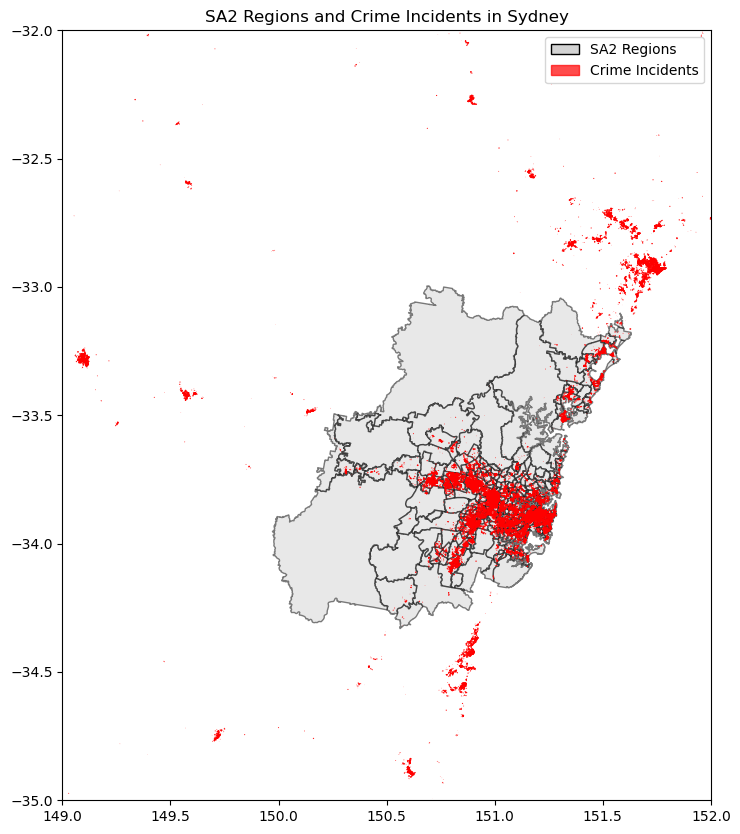

In [52]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

GS_SA2_geometry = GS_SA2[['geometry']]
Crime_geometry = Crime[['geometry']]

fig, ax = plt.subplots(figsize=(15, 10))
sa2_plot = GS_SA2_geometry.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)


Crime_plot = Crime_geometry.plot(ax=ax, color='red', markersize=5, alpha=0.7)
ax.set_xlim(149, 152)
ax.set_ylim(-35, -32)

# Create custom legend
legend_elements = [
    Patch(facecolor='lightgrey', edgecolor='black', label='SA2 Regions'),
    Patch(facecolor='red', edgecolor='red', label='Crime Incidents', alpha=0.7)
]

ax.legend(handles=legend_elements)
plt.title('SA2 Regions and Crime Incidents in Sydney')
plt.show()

In [53]:
pgquery(conn, "DROP TABLE IF EXISTS CRIME", msg="cleared old table")
CRIME_schema = '''CREATE TABLE CRIME (
                      SHAPE_AREA FLOAT,
                      GEOM GEOMETRY(POLYGON,4326),
                      SOURCE_FILE VARCHAR(200)
                      )''' 
pgquery(conn, CRIME_schema, msg="create new table")

success: cleared old table
success: create new table


In [54]:
insert_stmt = """INSERT INTO CRIME VALUES ( %(Shape_Area)s, ST_GeomFromText(%(geom_wkt)s, 4326), %(source_file)s)"""

Crime['geom_wkt'] = Crime['geometry'].apply(lambda x: x.wkt if x is not None else x)

for idx, row in Crime.iterrows():
    pgquery(conn, insert_stmt, args=row, msg="inserted")

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted


In [55]:
pgquery(conn,"""CREATE INDEX idx_geom_crime ON CRIME USING GIST (geom);""")
pd.read_sql_query("select * from CRIME", conn)

shape_area                                               geom  \
0       22500.000002  0103000020E61000000100000006000000A9426B76C9BC...   
1       87500.000001  0103000020E610000001000000130000005DB3D2C412BD...   
2       57499.999999  0103000020E61000000100000015000000298090EE33BB...   
3      260000.000000  0103000020E61000000100000022000000C4DA6307EEBA...   
4      338750.000003  0103000020E6100000010000001800000027704CFF06BB...   
...              ...                                                ...   
21504  392500.000001  0103000020E61000000100000024000000CB5FAF814131...   
21505  242499.999999  0103000020E61000000100000020000000A81ECCBDC530...   
21506  242499.999994  0103000020E6100000010000001B00000053F4DE020B31...   
21507    7500.000002  0103000020E61000000100000007000000A7295D8FCE30...   
21508  609999.999991  0103000020E6100000010000003D0000008245C57E6B31...   

                                  source_file  
0      AlcoholRelatedAssault_JanToDec2022.shp  
1      AlcoholRelatedAssault_JanToDec2022.shp  
2      AlcoholRelatedAssault_JanToDec2022.shp  
3      AlcoholRelatedAssault_JanToDec2022.shp  
4      AlcoholRelatedAssault_JanToDec2022.shp  
...                                       ...  
21504       StealFromVehicle_JanToDec2022.shp  
21505       StealFromVehicle_JanToDec2022.shp  
21506       StealFromVehicle_JanToDec2022.shp  
21507       StealFromVehicle_JanToDec2022.shp  
21508       StealFromVehicle_JanToDec2022.shp  

[21509 rows x 3 columns]

In [56]:
pgquery(conn, "DROP TABLE IF EXISTS Crime_hotspot_density", msg="Cleared old table")

crime_hotspot_schema = """
CREATE TABLE crime_hotspot_density AS
SELECT SA2.sa2_code, SA2.sa2_name, COUNT(CRIME.geom) AS crime_hotspot_count
FROM SA2
LEFT JOIN CRIME
ON ST_Intersects(CRIME.geom, SA2.geom)
GROUP BY SA2.sa2_code
ORDER BY crime_hotspot_count DESC;
"""

pgquery(conn, crime_hotspot_schema, msg="Create new table")

success: Cleared old table
success: Create new table


In [57]:
pd.read_sql_query( "SELECT * FROM crime_hotspot_density ORDER BY crime_hotspot_count DESC", conn)

sa2_code                      sa2_name  crime_hotspot_count
0    123021437       Campbelltown - Woodbine                  126
1    124031462        Kingswood - Werrington                  114
2    116011307    Lalor Park - Kings Langley                  106
3    102011032         Gosford - Springfield                  106
4    116021632             Schofields - East                  105
..         ...                           ...                  ...
368  115021298        Galston - Laughtondale                    1
369  115031299     Bilpin - Colo - St Albans                    1
370  122031432  Terrey Hills - Duffys Forest                    1
371  127011592                Badgerys Creek                    0
372  117011324        Port Botany Industrial                    0

[373 rows x 3 columns]

In [58]:
#Calculate Z score
pgquery(conn,"ALTER TABLE crime_hotspot_density ADD IF NOT EXISTS crime_score FLOAT") 
pd.read_sql_query(""" 
UPDATE crime_hotspot_density SET crime_score = (crime_hotspot_count - (SELECT AVG(crime_hotspot_count) FROM crime_hotspot_density)) / (SELECT STDDEV(crime_hotspot_count) FROM crime_hotspot_density);
SELECT * FROM crime_hotspot_density order by crime_score DESC;
""",conn)

sa2_code                      sa2_name  crime_hotspot_count  crime_score
0    123021437       Campbelltown - Woodbine                  126     3.461466
1    124031462        Kingswood - Werrington                  114     2.949165
2    102011032         Gosford - Springfield                  106     2.607631
3    116011307    Lalor Park - Kings Langley                  106     2.607631
4    116021632             Schofields - East                  105     2.564939
..         ...                           ...                  ...          ...
368  115021298        Galston - Laughtondale                    1    -1.875004
369  122031432  Terrey Hills - Duffys Forest                    1    -1.875004
370  115031299     Bilpin - Colo - St Albans                    1    -1.875004
371  127011592                Badgerys Creek                    0    -1.917695
372  117011324        Port Botany Industrial                    0    -1.917695

[373 rows x 4 columns]

## Dataset 2: Points of Interest in NSW

In [59]:
with open('data/546a65ab-a4ba-4f94-9f94-d45704a65c61/Points_Of_Interest_EPSG4326.json') as f:
    data = json.load(f)

poi_content = data['Points_Of_Interest']
features_list = poi_content['features']

poi_df = pd.json_normalize(features_list)

# Filter DataFrame to include only relevant columns
poi_filtered_df = poi_df[[
    'properties.poiname', 
    'properties.topoid',
    'properties.poitype',
    'geometry.coordinates'
]]

def convert_to_wkt(coord):
    return f'SRID=4326;POINT({coord[0]} {coord[1]})'

poi_filtered_df['geometry'] = poi_filtered_df['geometry.coordinates'].apply(convert_to_wkt)
print(poi_filtered_df.head())

         properties.poiname  properties.topoid properties.poitype  \
0         CARLINGFORD COURT          500168018    Shopping Centre   
1               ECCLES PARK          500168020        Picnic Area   
2        GREENWICH HOSPITAL          500168021   General Hospital   
3   LANE COVE BUSHLAND PARK          500168032               Park   
4  ST LEONARDS TAFE COLLEGE          500168054       TAFE College   

                        geometry.coordinates  \
0   [151.05229048007863, -33.77624547568138]   
1   [151.05374285916199, -33.81053427601384]   
2   [151.18341666109134, -33.82714790994467]   
3  [151.17926511856533, -33.823130729354865]   
4    [151.1865017398817, -33.82109867620087]   

                                            geometry  
0  SRID=4326;POINT(151.05229048007863 -33.7762454...  
1  SRID=4326;POINT(151.05374285916199 -33.8105342...  
2  SRID=4326;POINT(151.18341666109134 -33.8271479...  
3  SRID=4326;POINT(151.17926511856533 -33.8231307...  
4  SRID=4326;POINT(15

In [60]:
pgquery(conn, "DROP TABLE IF EXISTS POI", msg="cleared old table")
POI_schema = '''CREATE TABLE POI (
        poi_name VARCHAR(255),
        poi_id INTEGER,
        poi_type varchar(100),
        geometry GEOMETRY(Point, 4326) 
);''' 
pgquery(conn, POI_schema, msg="create new table")

success: cleared old table
success: create new table


In [61]:
insert_stmt = """INSERT INTO POI VALUES ( %(properties.poiname)s,  %(properties.topoid)s, %(properties.poitype)s, %(geometry)s )"""

for idx, row in poi_filtered_df.iterrows():
    pgquery(conn, insert_stmt, args=row, msg="inserted")

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: inserted
success: i

In [62]:
pgquery(conn,"""CREATE INDEX idx_geom_poi ON POI USING GIST (geometry);""")
pd.read_sql_query("select * from POI limit 5", conn)

poi_name     poi_id          poi_type  \
0         CARLINGFORD COURT  500168018   Shopping Centre   
1               ECCLES PARK  500168020       Picnic Area   
2        GREENWICH HOSPITAL  500168021  General Hospital   
3   LANE COVE BUSHLAND PARK  500168032              Park   
4  ST LEONARDS TAFE COLLEGE  500168054      TAFE College   

                                            geometry  
0  0101000020E61000008EBA155DACE1624018DC01035CE3...  
1  0101000020E6100000D1CFF142B8E162401CE24F96BFE7...  
2  0101000020E6100000B91D9E8CDEE56240641593FBDFE9...  
3  0101000020E6100000A7B1338ABCE56240B57405595CE9...  
4  0101000020E61000000C2E7FD2F7E562402B89ECC219E9...

In [63]:
pgquery(conn, "DROP TABLE IF EXISTS POI_density", msg="Cleared old table")

POI_schema = """
CREATE TABLE POI_density AS
SELECT SA2.sa2_code, SA2.sa2_name, COUNT(POI.geometry)/SA2.area AS POI_Count_perArea
FROM SA2
LEFT JOIN POI
ON ST_Within(POI.geometry, SA2.geom)
GROUP BY SA2.sa2_code
ORDER BY POI_COUNT_perArea DESC;
"""

pgquery(conn, POI_schema, msg="Create new table")

success: Cleared old table
success: Create new table


In [64]:
pd.read_sql_query( "SELECT * FROM POI_density ORDER BY POI_Count_perArea DESC", conn)

sa2_code                        sa2_name  poi_count_perarea
0    117031644  Sydney (North) - Millers Point          98.997572
1    120011385          Drummoyne - Rodd Point          72.340540
2    120021387                         Balmain          58.880496
3    117031329                    Darlinghurst          56.015871
4    117031645      Sydney (South) - Haymarket          52.728955
..         ...                             ...                ...
368  124021456          Blue Mountains - South           0.294679
369  124011451          Blue Mountains - North           0.284016
370  127011592                  Badgerys Creek           0.170674
371  115031299       Bilpin - Colo - St Albans           0.112029
372  123021439        Holsworthy Military Area           0.030811

[373 rows x 3 columns]

In [65]:
#Calculate Z score
pgquery(conn,"ALTER TABLE POI_density ADD IF NOT EXISTS POI_score FLOAT") 
pd.read_sql_query(""" 
UPDATE POI_density SET POI_score = (POI_Count_perArea - (SELECT AVG(POI_Count_perArea) FROM POI_density)) / (SELECT STDDEV(POI_Count_perArea) FROM POI_density);
SELECT * FROM POI_density order by POI_score DESC;
""",conn)

sa2_code                        sa2_name  poi_count_perarea  poi_score
0    117031644  Sydney (North) - Millers Point          98.997572   7.629312
1    120011385          Drummoyne - Rodd Point          72.340540   5.270892
2    120021387                         Balmain          58.880496   4.080046
3    117031329                    Darlinghurst          56.015871   3.826605
4    117031645      Sydney (South) - Haymarket          52.728955   3.535803
..         ...                             ...                ...        ...
368  124021456          Blue Mountains - South           0.294679  -1.103199
369  124011451          Blue Mountains - North           0.284016  -1.104142
370  127011592                  Badgerys Creek           0.170674  -1.114170
371  115031299       Bilpin - Colo - St Albans           0.112029  -1.119358
372  123021439        Holsworthy Military Area           0.030811  -1.126544

[373 rows x 4 columns]

### Add Z scores of two additional datasets to resource table

In [66]:
pgquery(conn,"ALTER TABLE Resource ADD IF NOT EXISTS Crime_score FLOAT") 

pgquery(conn,"""
UPDATE Resource
SET Crime_score = crime_hotspot_density.crime_score
FROM crime_hotspot_density
WHERE Resource.SA2_code = crime_hotspot_density.SA2_code;
""")

pgquery(conn,"ALTER TABLE Resource ADD IF NOT EXISTS POI_score FLOAT") 

pgquery(conn,"""
UPDATE Resource
SET POI_score = POI_density.POI_score
FROM POI_density
WHERE Resource.SA2_code = POI_density.SA2_code;
""")

pd.read_sql_query(""" SELECT * from Resource order by resource_score_A desc;""",conn)

sa2_code                            sa2_name  estate_score  stop_score  \
0    117031644      Sydney (North) - Millers Point     17.897674    0.338747   
1    115021297  Dural - Kenthurst - Wisemans Ferry      0.255201    6.337754   
2    117031645          Sydney (South) - Haymarket      2.430837   -0.842525   
3    102011030                     Calga - Kulnura      0.435810    0.257679   
4    123021437             Campbelltown - Woodbine     -0.157112    2.608641   
..         ...                                 ...           ...         ...   
347  102011033                             Kariong     -0.277920   -0.981498   
348  116021562                      Acacia Gardens     -0.253179   -1.282606   
349  102021052        Summerland Point - Gwandalan     -0.291854   -1.050984   
350  123011702                         Spring Farm     -0.303597   -1.189957   
351  127031730                      Edmondson Park     -0.245682   -1.189957   

     poll_score  school_score  resource_score_a  crime_score  poi_score  
0     14.476684      1.822414          1.000000    -0.252717   7.629312  
1      1.139642      0.243608          0.999657    -1.277319  -1.058030  
2      5.504492      0.445779          0.999468    -0.508867   3.535803  
3      0.654659      3.640934          0.993234    -1.063860  -1.083879  
4      1.624625     -0.150361          0.980655     3.461466  -0.318403  
..          ...           ...               ...          ...        ...  
347   -0.557800     -0.394291          0.098722    -0.935785  -0.703219  
348   -0.800291      0.038954          0.091362    -1.320011  -0.661951  
349   -0.557800     -0.510721          0.082311    -1.149244  -0.714824  
350   -0.800291     -0.123307          0.081874    -1.021169  -1.038676  
351   -0.800291     -0.279303          0.074797     0.003434  -0.939361  

[352 rows x 9 columns]

In [1]:
#ADD RESOURCE SCORE AFTER DATASETS
pgquery(conn,"ALTER TABLE Resource ADD IF NOT EXISTS resource_score_b FLOAT")

pgquery(conn,"""
UPDATE Resource 
SET resource_score_b = 1 / (1 + EXP(-(estate_score + stop_score + poll_score + school_score + crime_score + poi_score))) 
""")

pd.read_sql_query(""" SELECT * from Resource order by resource_score_b desc limit 10;""",conn)

NameError: name 'pgquery' is not defined

## Visualisations and data analysis

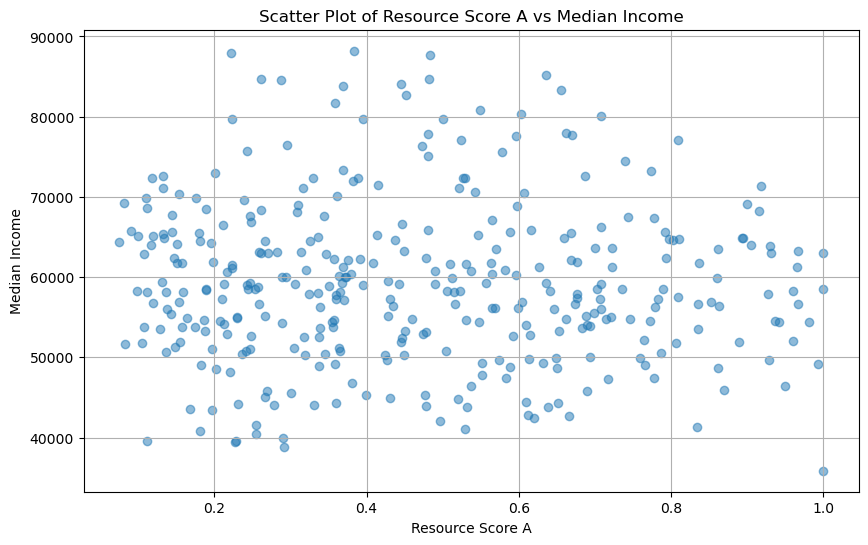

In [69]:
#Median Income vs scores plot 
pgquery(conn,"ALTER TABLE Resource ADD IF NOT EXISTS median_income FLOAT") 

pgquery(conn,"""
UPDATE Resource
SET median_income = INCOME.median_income
FROM INCOME
WHERE Resource.SA2_code = INCOME.SA2_code;
""")

df = pd.read_sql_query(""" SELECT * from Resource order by resource_score_A desc;""",conn)

plt.figure(figsize=(10, 6))
plt.scatter(df['resource_score_a'], df['median_income'], alpha=0.5)
plt.title('Scatter Plot of Resource Score A vs Median Income')
plt.xlabel('Resource Score A')
plt.ylabel('Median Income')
plt.grid(True)
plt.show()

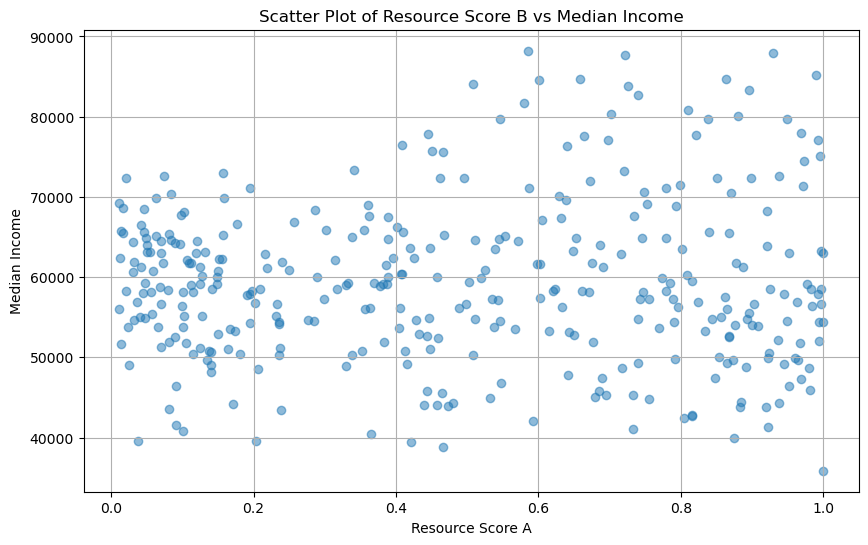

In [71]:
plt.figure(figsize=(10, 6))
plt.scatter(df['resource_score_b'], df['median_income'], alpha=0.5)
plt.title('Scatter Plot of Resource Score B vs Median Income')
plt.xlabel('Resource Score A')
plt.ylabel('Median Income')
plt.grid(True)
plt.show()

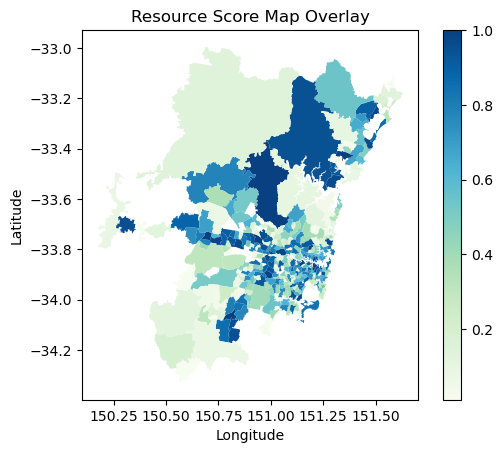

In [72]:
map_overlay = gpd.read_postgis("SELECT geom, resource_score_b FROM SA2 s JOIN Resource r ON (s.sa2_code = r.sa2_code)", conn, geom_col='geom')
#map_overlay['resource_score_b'] = map_overlay['resource_score_b'].apply(lambda x: sigmoid(x))
plt.rcParams
map_overlay.plot(column='resource_score_b', cmap='GnBu', legend=True)
plt.title('Resource Score Map Overlay')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.savefig('map.png')
plt.show()